<a href="https://colab.research.google.com/github/VavRe/nlp-ut/blob/main/CA3/Q1_Twitter_Sentiment_Analysis_OneHot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget http://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
!unzip trainingandtestdata.zip

URL transformed to HTTPS due to an HSTS policy
--2023-05-14 15:05:56--  https://cs.stanford.edu/people/alecmgo/trainingandtestdata.zip
Resolving cs.stanford.edu (cs.stanford.edu)... 171.64.64.64
Connecting to cs.stanford.edu (cs.stanford.edu)|171.64.64.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81363704 (78M) [application/zip]
Saving to: ‘trainingandtestdata.zip.7’

trainingandtestdata 100%[===================>]  77.59M  19.6MB/s    in 5.0s    

2023-05-14 15:06:02 (15.5 MB/s) - ‘trainingandtestdata.zip.7’ saved [81363704/81363704]

Archive:  trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace training.1600000.processed.noemoticon.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
n
n


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras.layers import Embedding, LSTM, Dense, Dropout, RNN
from keras.models import Sequential


In [4]:
columns = ["sentiment","id","datetime","query","user","tweet"]
df = pd.read_csv("/content/training.1600000.processed.noemoticon.csv", encoding="latin-1", names=columns)
df = df.loc[:,["sentiment","tweet"]]

In [5]:
from sklearn.model_selection import train_test_split

samples_fraction = 0.025
stratify_on = "sentiment"

_, dataset = train_test_split(df, stratify=df[stratify_on], 
                                 test_size=samples_fraction,
                                 random_state=76)

# Reset the index of the sampled DataFrame
dataset.reset_index(drop=True, inplace=True)


In [6]:
del df

In [7]:
import re
import nltk
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = stopwords.words('english')

def preprocess_tweet(tweet, remove_stopwords=True, stem_words=True, handle_negation=True):
    # Convert to lowercase
    tweet = tweet.lower()
    
    # Remove URLs, mentions, and hashtags
    tweet = re.sub(r"http\S+|www\S+|https\S+|\@\w+|\#\w+", "", tweet)
    
    # Remove punctuation
    tweet = re.sub(r'[^\w\s]', '', tweet)
    
    # Remove numbers
    tweet = re.sub(r'\d+', '', tweet)
    
    # Remove stopwords if specified
    if remove_stopwords:
        tweet_tokens = tweet.split()
        tweet = " ".join([word for word in tweet_tokens if word not in stop_words])
    
    # Stem words if specified
    if stem_words:
        stemmer = PorterStemmer()
        tweet_tokens = tweet.split()
        tweet = " ".join([stemmer.stem(word) for word in tweet_tokens])
        
    # Handle negation if specified
    if handle_negation:
        tweet_tokens = word_tokenize(tweet)
        negation_flag = False
        negated_tokens = []
        for i, token in enumerate(tweet_tokens):
            if token in ["not", "n't", "no"]:
                negation_flag = True
            elif negation_flag:
                negated_tokens.append("not_" + token)
                negation_flag = False
            else:
                negated_tokens.append(token)
        tweet = " ".join(negated_tokens)
    
    return tweet


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from tqdm import tqdm
tqdm.pandas()


dataset["tweet"] = dataset["tweet"].progress_apply(preprocess_tweet)

100%|██████████| 40000/40000 [00:12<00:00, 3117.40it/s]


In [9]:
from keras.utils import to_categorical
X = dataset["tweet"]
y = dataset["sentiment"]
y = y.replace(4,1)
y = y.replace(4,1)

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=76)

y_train = to_categorical(y_train, num_classes=2)
y_test = to_categorical(y_test, num_classes=2)
vocab_size = 5000


In [11]:
from sklearn.feature_extraction.text import CountVectorizer

# Define a sample text data

# Initialize the CountVectorizer
vectorizer = CountVectorizer(binary=True, max_features=vocab_size )

# Fit the vectorizer to the text data
vectorizer.fit(X_train)

# # Transform the text data into a one-hot encoded matrix
# X_train_onehot = vectorizer.transform(X_train)
# X_test_onehot = vectorizer.transform(X_test)

# Print the one-hot encoded data
# type(X_train_onehot)

CountVectorizer(binary=True, max_features=5000)

In [12]:
X_train_onehot = vectorizer.transform(X_train).toarray()


In [13]:
X_test_onehot = vectorizer.transform(X_test).toarray()

In [ ]:
def batch_generator(data, batch_size, vectorizer):
    num_batches = len(data) // batch_size
    while True:
        for i in range(num_batches):
            start = i * batch_size
            end = (i + 1) * batch_size
            batch = data[start:end]
            X_batch = vectorizer.transform(batch).toarray()
            yield X_batch


In [15]:
from keras.callbacks import ModelCheckpoint
from keras.layers import CuDNNLSTM, Dropout,SimpleRNN,Reshape
import tensorflow as tf

filepath = 'my_best_model.hdf5'

callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss",patience=5,restore_best_weights=True)
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')
opt = tf.keras.optimizers.Adam(learning_rate=0.01)
timesteps = 1
vocab_size = 5000
input_shape = (vocab_size,)

RNN_onehot = Sequential()
RNN_onehot.add(Dense(units=150, activation='relu', input_shape=input_shape))
RNN_onehot.add(Reshape((1, 150)))
RNN_onehot.add(SimpleRNN(150))
RNN_onehot.add(Dropout(0.2))
RNN_onehot.add(Dense(2, activation='softmax'))
RNN_onehot.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

gen = batch_generator(X_train, 128, vectorizer)

# X_train = X_train.to_numpy().reshape((X_train.shape[0], timesteps, vocab_size))
hist = RNN_onehot.fit(X_train_onehot, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[checkpoint,callback])


Epoch 1/100
798/800 [============================>.] - ETA: 0s - loss: 0.5881 - accuracy: 0.7003
Epoch 1: val_loss improved from inf to 0.55398, saving model to my_best_model.hdf5
800/800 [==============================] - 10s 9ms/step - loss: 0.5880 - accuracy: 0.7005 - val_loss: 0.5540 - val_accuracy: 0.7322
Epoch 2/100
800/800 [==============================] - ETA: 0s - loss: 0.4598 - accuracy: 0.7944
Epoch 2: val_loss did not improve from 0.55398
800/800 [==============================] - 5s 6ms/step - loss: 0.4598 - accuracy: 0.7944 - val_loss: 0.5572 - val_accuracy: 0.7312
Epoch 3/100
799/800 [============================>.] - ETA: 0s - loss: 0.2995 - accuracy: 0.8771
Epoch 3: val_loss did not improve from 0.55398
800/800 [==============================] - 5s 7ms/step - loss: 0.2996 - accuracy: 0.8771 - val_loss: 0.6666 - val_accuracy: 0.7211
Epoch 4/100
796/800 [============================>.] - ETA: 0s - loss: 0.1621 - accuracy: 0.9358
Epoch 4: val_loss did not improve from 0.

250/250 [==============================] - 1s 2ms/step


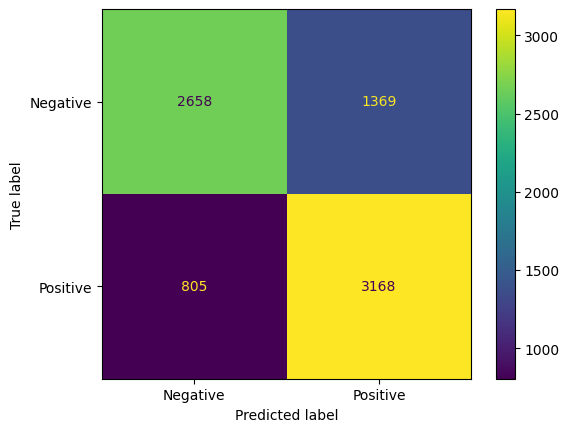

              precision    recall  f1-score   support

    Negative       0.77      0.66      0.71      4027
    Positive       0.70      0.80      0.74      3973

    accuracy                           0.73      8000
   macro avg       0.73      0.73      0.73      8000
weighted avg       0.73      0.73      0.73      8000



In [16]:
y_pred = RNN_onehot.predict(X_test_onehot)
     

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt



y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
conf_mat = confusion_matrix(y_true_classes, y_pred_classes)
disp = ConfusionMatrixDisplay(conf_mat, display_labels=['Negative', 'Positive'])
disp.plot()
plt.show()

     

from sklearn.metrics import classification_report
target_names = ["Negative","Positive"]
print(classification_report(y_true_classes, y_pred_classes, target_names=target_names))



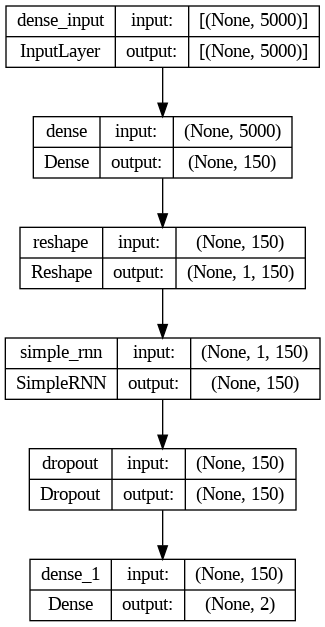

In [17]:
from keras.utils.vis_utils import plot_model


plot_model(RNN_onehot, to_file='model.png', show_shapes=True, show_layer_names=True)
